# Análisis de Datos Científicos y Geográficos
### TP: Datos Científicos
<u>Alumna</u>: Araceli Fernández Ferrara <br>
<u>Profesor</u>: Rodrigo Ramele

En el siguiente trabajo, analizaremos la información de ondas cerebrales recolectada a traves de sensores que fueron colocados en una compañera. El objetivo es crear un modelo que permita clasificar ambas muestras, para ello usaremos una SVM.

In [1]:
#librerias:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
import math
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, filtfilt, buttord
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

##### Análisis de la información:

Analizamos la muestra ojos abiertos, el sujeto en se encontraba con los ojos abiertos frente a un grupo de personas.

      timestamp  counter  eeg  attention  meditation  blinking
0  1.702340e+09       68   83          0           0         0
1  1.702340e+09       69   70          0           0         0
2  1.702340e+09       70   71          0           0         0
3  1.702340e+09       71   60          0           0         0
4  1.702340e+09       72   36          0           0         0


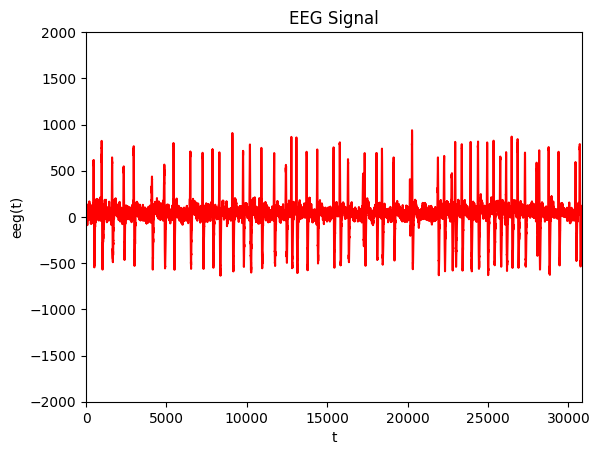

In [2]:
signals = pd.read_csv('data/ojosabiertos.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])
print(signals.head())

ojosabiertos = signals.values

eeg = ojosabiertos[:,2]

#gráfico:
plt.plot(eeg,'r', label='EEG')
plt.xlabel('t');
plt.ylabel('eeg(t)');
plt.title(r'EEG Signal')     
plt.ylim([-2000, 2000]);
plt.xlim([0,len(eeg)])
plt.savefig('grafico.eps')
plt.show()

Analizamos la muestra si, en este caso el sujeto y todos los participantes del grupo estaban diciendo "si" y asintiendo con la cabeza.

      timestamp  counter  eeg  attention  meditation  blinking
0  1.702341e+09       33  -49          0           0         0
1  1.702341e+09       34  -71          0           0         0
2  1.702341e+09       35  -82          0           0         0
3  1.702341e+09       36  -23          0           0         0
4  1.702341e+09       37   60          0           0         0


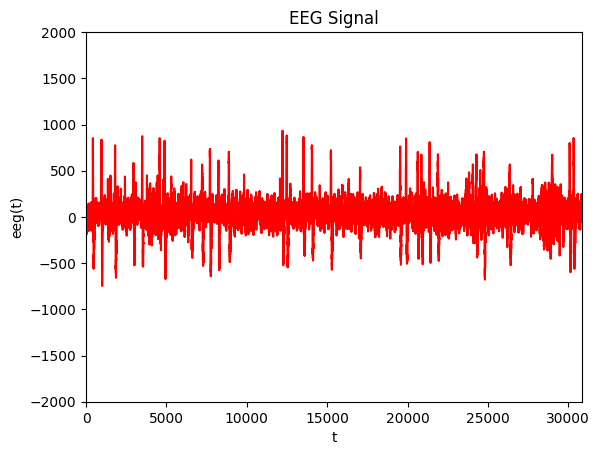

In [3]:
signals_2 = pd.read_csv('data/si.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])
print(signals_2.head())

si = signals_2.values

eeg_2 = si[:,2]

#grafico:
plt.plot(eeg_2,'r', label='EEG')
plt.xlabel('t');
plt.ylabel('eeg(t)');
plt.title(r'EEG Signal')     
plt.ylim([-2000, 2000]);
plt.xlim([0,len(eeg_2)])
plt.savefig('grafico.eps')
plt.show()

##### Creación de signal features:

In [5]:
###Signal features:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def psd(y):
    # Number of samplepoints
    N = 128
    # sample spacing
    T = 1.0 / 128.0
    # From 0 to N, N*T, 2 points.
    #x = np.linspace(0.0, 1.0, N)
    #y = 1*np.sin(10.0 * 2.0*np.pi*x) + 9*np.sin(20.0 * 2.0*np.pi*x)


    # Original Bandpass
    fs = 128.0
    fso2 = fs/2
    #Nd,wn = buttord(wp=[9/fso2,11/fso2], ws=[8/fso2,12/fso2],
    #   gpass=3.0, gstop=40.0)
    #b,a = butter(Nd,wn,'band')
    #y = filtfilt(b,a,y)

    y = butter_bandpass_filter(y, 8.0, 15.0, fs, order=6)


    yf = fft(y)
    #xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))
    #import matplotlib.pyplot as plt
    #plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
    #plt.axis((0,60,0,1))
    #plt.grid()
    #plt.show()

    return np.sum(np.abs(yf[0:int(N/2)]))


def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))

def hjorth(a):
    r"""
    Compute Hjorth parameters [HJO70]_.
    .. math::
        Activity = m_0 = \sigma_{a}^2
    .. math::
        Complexity = m_2 = \sigma_{d}/ \sigma_{a}
    .. math::
        Morbidity = m_4 =  \frac{\sigma_{dd}/ \sigma_{d}}{m_2}
    Where:
    :math:`\sigma_{x}^2` is the mean power of a signal :math:`x`. That is, its variance, if it's mean is zero.
    :math:`a`, :math:`d` and :math:`dd` represent the original signal, its first and second derivatives, respectively.
    .. note::
        **Difference with PyEEG:**
        Results is different from [PYEEG]_ which appear to uses a non normalised (by the length of the signal) definition of the activity:
        .. math::
            \sigma_{a}^2 = \sum{\mathbf{x}[i]^2}
        As opposed to
        .. math::
            \sigma_{a}^2 = \frac{1}{n}\sum{\mathbf{x}[i]^2}
    :param a: a one dimensional floating-point array representing a time series.
    :type a: :class:`~numpy.ndarray` or :class:`~pyrem.time_series.Signal`
    :return: activity, complexity and morbidity
    :rtype: tuple(float, float, float)
    Example:
    >>> import pyrem as pr
    >>> import numpy as np
    >>> # generate white noise:
    >>> noise = np.random.normal(size=int(1e4))
    >>> activity, complexity, morbidity = pr.univariate.hjorth(noise)
    """

    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    morbidity = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / morbidity

    return activity, morbidity, complexity

def pfd(a):
    r"""
    Compute Petrosian Fractal Dimension of a time series [PET95]_.
    It is defined by:
    .. math::
        \frac{log(N)}{log(N) + log(\frac{N}{N+0.4N_{\delta}})}
    .. note::
        **Difference with PyEEG:**
        Results is different from [PYEEG]_ which implemented an apparently erroneous formulae:
        .. math::
            \frac{log(N)}{log(N) + log(\frac{N}{N}+0.4N_{\delta})}
    Where:
    :math:`N` is the length of the time series, and
    :math:`N_{\delta}` is the number of sign changes.
    :param a: a one dimensional floating-point array representing a time series.
    :type a: :class:`~numpy.ndarray` or :class:`~pyrem.time_series.Signal`
    :return: the Petrosian Fractal Dimension; a scalar.
    :rtype: float
    Example:
    >>> import pyrem as pr
    >>> import numpy as np
    >>> # generate white noise:
    >>> noise = np.random.normal(size=int(1e4))
    >>> pr.univariate.pdf(noise)
    """

    diff = np.diff(a)
    # x[i] * x[i-1] for i in t0 -> tmax
    prod = diff[1:-1] * diff[0:-2]

    # Number of sign changes in derivative of the signal
    N_delta = np.sum(prod < 0)
    n = len(a)

    return np.log(n)/(np.log(n)+np.log(n/(n+0.4*N_delta)))


Aplicamos los features creados previamente al dataset de ojos abiertos, particionamos los datos creando una ventana de tiempo.

Temporal Features
Shape 30850, 6:
Peak-To-Peak:1574.0
Root Mean Square:203.56035044252909
Crest Factor:4.607970058809779
Shannon Entropy:8.64899071407741
Activity:41436.81627228525
Complexity:0.097688790238713
Mobidity:9.343608039920838
Fractal:1.0106825249255231


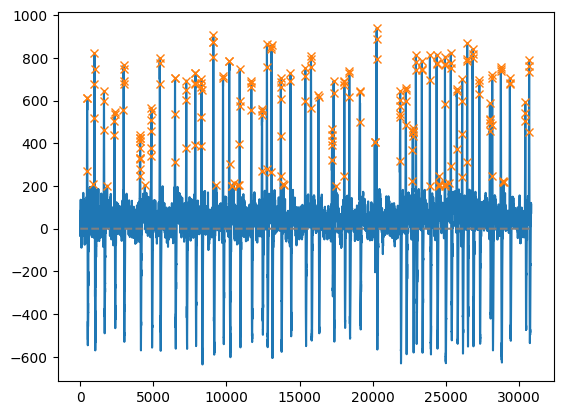

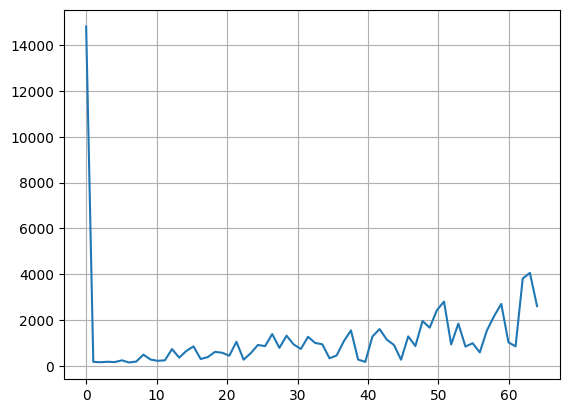

[ 83  70  71 ...  92  98 112]


[2.6612048308601914,
 2.9125078476416446,
 2.4896467413687224,
 2.465225213242404,
 2.7219865869749484,
 3.5271894961053634,
 3.3498272684329304,
 2.8338232548861133,
 1.8825289486272356,
 1.705463493360667,
 2.09312856578549,
 2.454480172241502,
 1.8016433498335012,
 1.9943289458861846,
 2.5557740427255946,
 2.615604232168481,
 2.6349950763511925,
 2.95425877999703,
 2.198647808143855,
 1.9017851997206368,
 1.942092895695719,
 2.787289048018451,
 2.024731794414374,
 2.108578558382933,
 3.235742310704694,
 3.1307886936993787,
 3.160542436122738,
 3.427219073926435,
 3.0196582324678034,
 2.218765242859588,
 3.07475091220769,
 2.04316408764016,
 1.8325784177428108,
 1.9748615802011376,
 2.0856378920057517,
 1.7061384548665768,
 2.0093558444194817,
 1.7288838430851203,
 2.0182026091427736,
 2.3776645812120707,
 3.1064838037015474,
 3.2604330550245906,
 2.494967628321774,
 2.33827684955617,
 3.7263286968202265,
 2.343783454051977,
 1.7361558418370011,
 2.0632383444428357,
 2.67623053324902

In [6]:
print('Temporal Features')

print('Shape %2d,%2d:' % (ojosabiertos.shape))
    
ptp = abs(np.max(eeg)) + abs(np.min(eeg))
rms = np.sqrt(np.mean(eeg**2))
cf = crest_factor(eeg)

print ('Peak-To-Peak:' + str(ptp))
print ('Root Mean Square:' + str(rms))
print ('Crest Factor:' + str(cf))

entropy = stats.entropy(list(Counter(eeg).values()), base=2)

print('Shannon Entropy:' + str(entropy))

activity, complexity, morbidity = hjorth(eeg)

print('Activity:' + str(activity))
print('Complexity:' + str(complexity))
print('Mobidity:' + str(morbidity))

fractal = pfd(eeg)
print('Fractal:' + str(fractal))

peaks, _ = find_peaks(eeg, height=200)
plt.plot(eeg)
plt.plot(peaks, eeg[peaks], "x")
plt.plot(np.zeros_like(eeg), "--", color="gray")
plt.show()

N = 128
T = 1.0 / 128.0

shamsignal = False
if (shamsignal):
    x= np.linspace(0.0, 1.0, N)
    eeg = eeg[:128] +  100*np.sin(10.0 * 2.0*np.pi*x)


yf = fft(eeg)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.close()

plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.show()

window_size = 128  
step_size = 50

eeg_ojos_abiertos = signals['eeg'].values

print(eeg_ojos_abiertos)

crest = []

for i in range(0, len(eeg_ojos_abiertos) - window_size + 1, step_size):
    window = eeg_ojos_abiertos[i:i+window_size]

    crest_val = crest_factor(window)

    crest.append(crest_val)

crest

Repetimos el mismo proceso con el dataset si

Temporal Features
Shape 30856, 6:
Peak-To-Peak:1680.0
Root Mean Square:170.7322219329749
Crest Factor:5.464697814137696
Shannon Entropy:8.989735772645428
Activity:29149.4916061706
Complexity:0.24168650865357677
Mobidity:4.314974030997223
Fractal:1.0122845334651513


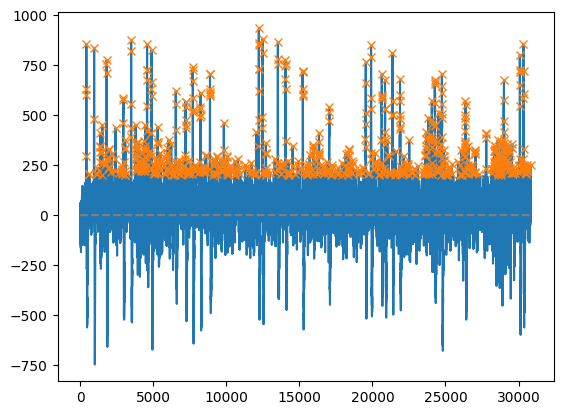

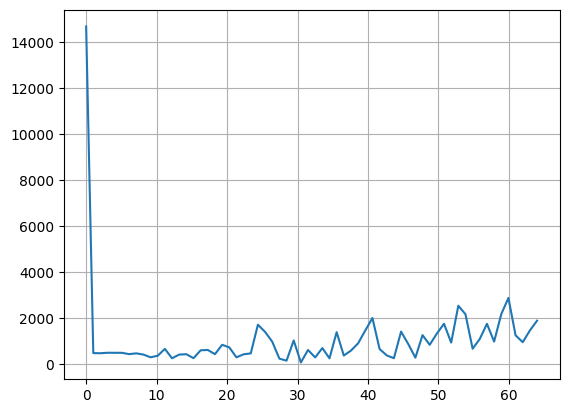

PSD:7040.843080955765
[-49 -71 -82 ...  71  89  89]


[2.630347447005344,
 2.8205958539331104,
 2.231877120909061,
 2.0433843680815786,
 2.089411478147897,
 2.369395110122711,
 4.3152957508749274,
 2.6395074553301914,
 2.200172490791921,
 2.0617927774840292,
 2.526615925174637,
 2.0654215662357363,
 2.441329159058987,
 2.8887418426941127,
 3.2922801182291335,
 3.1910999116782275,
 3.226762474937346,
 2.656174845588378,
 1.8222780677680526,
 1.8525237288358583,
 2.3943258905642315,
 2.2051749022786247,
 2.5026826874683152,
 3.0522742149077406,
 2.5144808293181495,
 2.675014650172968,
 2.372705401840205,
 2.293357435534279,
 2.947603157253892,
 2.960843621092814,
 3.005608462687002,
 2.0319323361473582,
 2.0372595047139748,
 2.4199858486007026,
 2.3876484944861143,
 1.816147189652509,
 1.7964132767197212,
 2.133994480475377,
 2.438279349859019,
 2.592930146869434,
 2.2203834203538877,
 3.1490608909392597,
 2.9090548563424656,
 3.0114358680240167,
 2.1413696997439358,
 3.1967068778481553,
 3.1414590014650994,
 3.006574683545295,
 3.015421032

In [7]:
print('Temporal Features')

print('Shape %2d,%2d:' % (si.shape))
    
ptp = abs(np.max(eeg_2)) + abs(np.min(eeg_2))
rms = np.sqrt(np.mean(eeg_2**2))
cf = crest_factor(eeg_2)

print ('Peak-To-Peak:' + str(ptp))
print ('Root Mean Square:' + str(rms))
print ('Crest Factor:' + str(cf))

entropy = stats.entropy(list(Counter(eeg_2).values()), base=2)

print('Shannon Entropy:' + str(entropy))

activity, complexity, morbidity = hjorth(eeg_2)

print('Activity:' + str(activity))
print('Complexity:' + str(complexity))
print('Mobidity:' + str(morbidity))

fractal = pfd(eeg_2)
print('Fractal:' + str(fractal))

peaks, _ = find_peaks(eeg_2, height=200)
plt.plot(eeg_2)
plt.plot(peaks, eeg_2[peaks], "x")
plt.plot(np.zeros_like(eeg_2), "--", color="gray")
plt.show()

N = 128
T = 1.0 / 128.0

shamsignal = False
if (shamsignal):
    x= np.linspace(0.0, 1.0, N)
    eeg_2 = eeg_2[:128] +  100*np.sin(10.0 * 2.0*np.pi*x)


yf = fft(eeg_2)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.close()

plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.show()

print('PSD:' + str(psd(eeg_2[:128])))

window_size = 128
step_size = 50

eeg_si = signals_2['eeg'].values

print(eeg_si)

crest_2 = []

for i in range(0, len(eeg_si) - window_size + 1, step_size):
    window = eeg_si[i:i+window_size]

    crest_val_2 = crest_factor(window)

    crest_2.append(crest_val_2)

crest_2

##### SVM:

El modelo obtenido tiene un accuracy de 70.7% lo cual indica que es bueno realizando las predicciones

In [8]:
df_crest = pd.DataFrame(crest, columns=['crest_values'])
df_crest['label'] = '0'
print(df_crest)

df_crest_2 = pd.DataFrame(crest_2, columns=['crest_values'])
df_crest_2['label'] = '1'
print(df_crest_2)

df_base = pd.concat([df_crest, df_crest_2])
print(df_base)

x = df_base[['crest_values']]
y = df_base['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


     crest_values label
0        2.661205     0
1        2.912508     0
2        2.489647     0
3        2.465225     0
4        2.721987     0
..            ...   ...
610      2.377117     0
611      1.979469     0
612      2.349958     0
613      1.910812     0
614      1.839287     0

[615 rows x 2 columns]
     crest_values label
0        2.630347     1
1        2.820596     1
2        2.231877     1
3        2.043384     1
4        2.089411     1
..            ...   ...
610      1.830069     1
611      2.120864     1
612      3.007788     1
613      2.386170     1
614      2.872174     1

[615 rows x 2 columns]
     crest_values label
0        2.661205     0
1        2.912508     0
2        2.489647     0
3        2.465225     0
4        2.721987     0
..            ...   ...
610      1.830069     1
611      2.120864     1
612      3.007788     1
613      2.386170     1
614      2.872174     1

[1230 rows x 2 columns]
Accuracy: 0.7073170731707317
